In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob 
import os
print(os.getcwd())

/home/savvyfox/Projects/scg-exp/examples/rl


In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w) / w, mode='valid')
    
def load_from_log_file(path):
    '''Return x, y sequence data from the stat csv.'''
    with open(path, 'r') as f:
        lines = f.readlines()
    # Labels.
    xk, yk = [k.strip() for k in lines[0].strip().split(',')]
    # Values.
    x, y = [], []
    for line in lines[1:]:
        data = line.strip().split(',')
        x.append(float(data[0].strip()))
        y.append(float(data[1].strip()))
    x = np.array(x)
    y = np.array(y)
    return xk, x, yk, y

In [3]:
plot_colors = {
    'GP-MPC': 'royalblue',
    'PPO': 'darkorange',
    'SAC': 'red',
    'DPPO': 'pink',
    'iLQR': 'darkgray',
    'Linear MPC': 'green',
    'Nonlinear MPC': 'cadetblue',
    "iLQR": "tab:gray",
    'MAX': 'none',
    'MIN': 'none',
}

ref_color = 'black'

gpmpc_color = 'royalblue'
gpmpc_hull_color = 'cornflowerblue'
lmpc_color = 'green'
lmpc_hull_color = 'lightgreen'
mpc_color = 'aqua'
mpc_hull_color = 'paleturquoise'

ppo_color = 'darkorange'
ppo_hull_color = 'moccasin'
sac_color = 'red'
sac_hull_color = 'salmon'
td3_color = 'pink'
td3_hull_color = 'lavenderblush'

legends = {
    "ref": "black",
    "PPO": "PPO",
    "PPO3": "PPO with ilqr ref",
    "PPO4": "PPO with ilqr state ref",
    "SAC": "SAC",
    "TD3": "TD3",
    "DPPO": "DPPO",
    "GP-MPC": "GP-MPC",
    "PPO-MPC": "PPO-MPC"
}

In [247]:
#data_dir = "/home/savvyfox/Misc/lsy_workstation_02/Projects/scg-exp/examples/rl/Results/prefinal"

#data_dir = "/home/savvyfox/Misc/lsy_workstation_02/Projects/scg-exp/examples/rl/Results/prefinal_ilqr_ref"
data_dir = "/home/savvyfox/Misc/Olaf/Projects/scg-exp/examples/rl/Results/prefinal_ilqr_ref"
#data_dir = "/home/savvyfox/Misc/ThinkPad_LSY/Misc/lsy_1/Projects/scg-exp/examples/rl/Results/New_batch/hpo_param"
#data_dir="/home/savvyfox/Misc/lsy_workstation_02/Misc/WS_08/Projects/scg-exp/examples/rl/Results/New_batch/default_param"
data_paths = {
    "PPO": data_dir + "/nominal/quadrotor_2D_attitude_ppo_data",
    "DPPO": data_dir + "/nominal/quadrotor_2D_attitude_dppo_data",
}
#data_paths = {
#    "PPO": data_dir + "/wt_1/quadrotor_2D_attitude_ppo_data",
#    "PPO1": data_dir + "/wt_2/quadrotor_2D_attitude_ppo_data",
#    "PPO2": data_dir + "/wt_3/quadrotor_2D_attitude_ppo_data",
#    "PPO3": data_dir + "/wt_5/quadrotor_2D_attitude_ppo_data",
#    "PPO4": data_dir + "/wt_8/quadrotor_2D_attitude_ppo_data",
#    "PPO5": data_dir + "/wt_10/quadrotor_2D_attitude_ppo_data",
#    "PPO6": data_dir + "/wt_15/quadrotor_2D_attitude_ppo_data"
#}

### Convergence plot

In [202]:
perf_data = {}
for method in data_paths.keys():
    print(method)
    perf_data.update({method: {}})
    temp = [x for x in os.listdir(data_paths[method])]
    for sd in os.listdir(data_paths[method]):
        seed = sd[4]
        xk, x, lk, l = load_from_log_file(data_paths[method] +"/"+sd+ "/logs/stat_eval/ep_length.log")
        xk, x, yk, y = load_from_log_file(data_paths[method] +"/"+sd+ "/logs/stat_eval/ep_return.log")
        xk, x, zk, z = load_from_log_file(data_paths[method] +"/"+sd+ "/logs/stat_eval/ep_return_std.log")
        # xk, x, ck, c = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/constraint_violation.log")
        # perf_data[method].update({seed: {"x": x, "y": y, "c": c}})
        # perf_data[method].update({seed: {"x": x, "y": y, "z": z, "c": c}})
        xk, x, yk, m = load_from_log_file(data_paths[method] +"/"+sd+ "/logs/stat_eval/rmse.log")
        xk, x, yk, n = load_from_log_file(data_paths[method] +"/"+sd+ "/logs/stat_eval/rmse_std.log")
        # perf_data[method].update({"x": x, "y": y, "z": z, "x1": x1, "y1": y1, "z1": z1})
        perf_data[method].update({int(seed): {"data": x, "ep_return": y, "ep_return_std": z, "rmse": m, "rmse_std": n, "ep_length": l}})

PPO
DPPO


In [259]:
gp_name = 'gpmpc_100_200.npy'
gp_mpc_data = np.load("./Data/" + gp_name, allow_pickle=True).item()
gp_mpc_data['rmse'][:,-1].var()

2.256972989252019e-06

PPO
DPPO


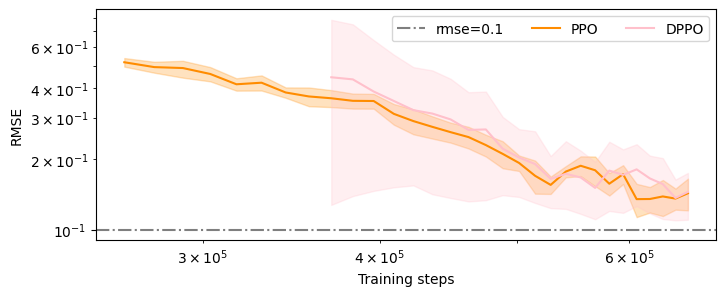

In [203]:
eval_data = {}
mean_fn = np.percentile
perc = 80
n_seeds = 5
seeds = [i for i in range(0, n_seeds)]

fig = plt.figure(figsize=(8, 3)) 
plt.axhline(xmin=0.0, xmax=1.95, y=0.1, linestyle='-.', color=plot_colors["iLQR"], label='rmse=0.1')

# p1 = 0.06556989411791102
# p2 = 0.0035402446045955343
# plt.axhline(xmin=0.0, xmax=1.95, y=p1, linestyle='--', color=plot_colors["Linear MPC"], label='Linear MPC')
# plt.fill_between([0.0, last_iter], p1-w*p2, p1+w*p2, color=plot_colors["Linear MPC"], alpha=0.25)

#p1 = 0.05281402034468281
#p2 = 0.0008527367355016513
#plt.axhline(xmin=0.0, xmax=1.95, y=p1, linestyle='--', color=plot_colors["Nonlinear MPC"], label='Nonlinear MPC')
#plt.fill_between([0.0, 660000.0], p1-p2, p1+p2, color=plot_colors["Nonlinear MPC"], alpha=0.25)


#gp_name = 'gpmpc_100_200_tr.npy'
#gp_mpc_data = np.load("./Data/" + gp_name, allow_pickle=True).item()
#plt.plot(gp_mpc_data['train_steps']+1, mean_fn(gp_mpc_data['rmse'], perc, axis=0), color=plot_colors["GP-MPC"], label='GP-MPC')
#plt.fill_between(gp_mpc_data['train_steps']+1, 
#                 np.clip(mean_fn(gp_mpc_data['rmse'], perc, axis=0)-gp_mpc_data['rmse'].std(axis=0), 0, 10), 
#                 np.clip(mean_fn(gp_mpc_data['rmse'], perc, axis=0)+gp_mpc_data['rmse'].std(axis=0), 0, 10), 
#                 color=plot_colors["GP-MPC"], alpha=0.25)

for t, method in enumerate(data_paths.keys()):
    print(method)
    temp = np.zeros((n_seeds, 6, perf_data[method][seeds[0]]["data"].shape[0]))
    for seed in seeds:
        temp[seed, 0, :] = perf_data[method][seed]["data"]
        temp[seed, 1, :] = perf_data[method][seed]["ep_return"]
        temp[seed, 2, :] = perf_data[method][seed]["ep_return_std"]
        temp[seed, 3, :] = perf_data[method][seed]["rmse"]
        temp[seed, 4, :] = perf_data[method][seed]["rmse_std"]
        temp[seed, 5, :] = perf_data[method][seed]["ep_length"]
    j_max = 0
    for seed in seeds:
        for j,k in enumerate(temp[seed, 0, :]):
            if temp[seed, 5, j] < 660:
                temp[seed, 1, j] = np.nan
                temp[seed, 2, j] = np.nan
                temp[seed, 3, j] = np.nan
                temp[seed, 4, j] = np.nan
                if j >= j_max:
                    j_max = j+1
    eval_data.update({method: temp})

    plt.plot(1+temp[0,0,:], mean_fn(temp[:,3,:], perc, axis=0), color=plot_colors[method], label=legends[method])
    plt.fill_between(1+temp[0,0,:], 
                     0.0+np.clip(mean_fn(temp[:,3,:]-temp[:,4,:], perc, axis=0), 0, 10),  
                     0.0+np.clip(mean_fn(temp[:,3,:]+temp[:,4,:], perc, axis=0), 0, 10), color=plot_colors[method], alpha=0.25)

plt.legend(ncol=3)
# plt.xlim(-10000, 460000)
# plt.xlim(1, 800000)
plt.xscale("log")
plt.yscale("log")
# plt.text(900, 0.3, "Unssucessful evaluation runs", bbox=dict(facecolor='red', alpha=0.25))
plt.xlabel("Training steps")
plt.ylabel("RMSE")
#plt.title("Task: Quadrotor 2D")
plt.savefig("performance_linearx.pdf",bbox_inches="tight", pad_inches=0.1)

In [204]:
perf_data

{'PPO': {1: {'data': array([ 13200.,  26400.,  39600.,  52800.,  66000.,  79200.,  92400.,
          105600., 118800., 132000., 145200., 158400., 171600., 184800.,
          198000., 211200., 224400., 237600., 250800., 264000., 277200.,
          290400., 303600., 316800., 330000., 343200., 356400., 369600.,
          382800., 396000., 409200., 422400., 435600., 448800., 462000.,
          475200., 488400., 501600., 514800., 528000., 541200., 554400.,
          567600., 580800., 594000., 607200., 620400., 633600., 646800.,
          660000.]),
   'ep_return': array([ 36.58057153,  73.05301547, 136.75659342, 247.51818827,
          287.73189702, 329.28863078, 349.62350374, 376.21233157,
          380.99174447, 405.40408621, 413.63697707, 429.97683523,
          420.04598319, 427.40897928, 439.31284845, 457.20698516,
          459.14414461, 466.61402471, 480.93269805, 486.79009839,
          482.86731599, 483.54170587, 487.96389666, 495.58697445,
          497.5421438 , 498.4667059 , 504

### Performance metric

In [205]:
perf_metric = {}
for method in data_paths.keys():
    print(method)
    perf_metric.update({method: {'rmse': [], 'rmse_std': [], 'success': []}})
    for seed in seeds:
        path = data_paths[method] + "/seed"+ str(seed) +"_*/perf_metric.npy"
        file_path = glob.glob(path)
        temp = np.load(file_path[0], allow_pickle=True).item()
        perf_metric[method]['rmse'].append(temp['rmse'])
        perf_metric[method]['rmse_std'].append(temp['rmse_std'])
        temp2 = True if temp['average_length'] == 660.0 else False
        perf_metric[method]['success'].append(temp2)
print(f"Performance of PPO is {np.array(perf_metric['PPO']['rmse']).mean()} +/- {np.array(perf_metric['PPO']['rmse']).std()}")
print(f"Performance of SAC is {np.array(perf_metric['SAC']['rmse']).mean()} +/- {np.array(perf_metric['SAC']['rmse']).std()}")
print(f"Performance of DPPO is {np.array(perf_metric['DPPO']['rmse']).mean()} +/- {np.array(perf_metric['DPPO']['rmse']).std()}")

PPO


IndexError: list index out of range

### Generalization metric

In [248]:
transfer_metric = {}
for method in data_paths.keys():
    print(method)
    transfer_metric.update({method: {'rmse': [], 'rmse_std': [], 'success': []}})
    for seed in seeds:
        path = data_paths[method] + "/seed"+ str(seed) +"_*/transfer_metric_11.npy"
        file_path = glob.glob(path)
        print(file_path)
        temp = np.load(file_path[0], allow_pickle=True).item()
        transfer_metric[method]['rmse'].append(temp['rmse'])
        transfer_metric[method]['rmse_std'].append(temp['rmse_std'])
        temp2 = True if temp['average_length'] == 660.0 else False
        transfer_metric[method]['success'].append(temp2)
print(f"Performance of PPO is {np.array(transfer_metric['PPO']['rmse']).mean()} +/- {np.array(transfer_metric['PPO']['rmse']).std()}")
#print(f"Performance of SAC is {np.array(transfer_metric['SAC']['rmse']).mean()} +/- {np.array(transfer_metric['SAC']['rmse']).std()}")
print(f"Performance of DPPO is {np.array(transfer_metric['DPPO']['rmse']).mean()} +/- {np.array(transfer_metric['DPPO']['rmse']).std()}")

PPO
['/home/savvyfox/Misc/Olaf/Projects/scg-exp/examples/rl/Results/prefinal_ilqr_ref/nominal/quadrotor_2D_attitude_ppo_data/seed0_Feb-09-23-55-53_a1063fb/transfer_metric_11.npy']
['/home/savvyfox/Misc/Olaf/Projects/scg-exp/examples/rl/Results/prefinal_ilqr_ref/nominal/quadrotor_2D_attitude_ppo_data/seed1_Feb-10-01-01-25_a1063fb/transfer_metric_11.npy']
['/home/savvyfox/Misc/Olaf/Projects/scg-exp/examples/rl/Results/prefinal_ilqr_ref/nominal/quadrotor_2D_attitude_ppo_data/seed2_Feb-10-02-13-29_a1063fb/transfer_metric_11.npy']
['/home/savvyfox/Misc/Olaf/Projects/scg-exp/examples/rl/Results/prefinal_ilqr_ref/nominal/quadrotor_2D_attitude_ppo_data/seed3_Feb-10-03-26-47_a1063fb/transfer_metric_11.npy']
['/home/savvyfox/Misc/Olaf/Projects/scg-exp/examples/rl/Results/prefinal_ilqr_ref/nominal/quadrotor_2D_attitude_ppo_data/seed4_Feb-10-04-38-38_a1063fb/transfer_metric_11.npy']
DPPO
['/home/savvyfox/Misc/Olaf/Projects/scg-exp/examples/rl/Results/prefinal_ilqr_ref/nominal/quadrotor_2D_attitude

In [219]:
episode_len_list = [9, 10, 11, 12, 13, 14, 15]
episode_len_list2 = [4.5, 5, 5.5, 6, 6.5, 7, 7.5]
transfer_metric = {}
for method in data_paths.keys():
    print(method)
    transfer_metric.update({method: {'rmse': [], 'rmse_std': []}})
    for T in episode_len_list:
        rmse, rmse_std = [], []
        for seed in seeds:
            path = data_paths[method] + "/seed"+ str(seed) +"_*/transfer_metric_"+str(T)+".npy"
            file_path = glob.glob(path)
            temp = np.load(file_path[0], allow_pickle=True).item()
            rmse.append(temp['rmse'])
            rmse_std.append(temp['rmse_std'])
        transfer_metric[method]['rmse'].append(np.array(rmse).mean())
        transfer_metric[method]['rmse_std'].append(np.array(rmse_std).mean())
    transfer_metric[method]['rmse'] = np.array(transfer_metric[method]['rmse'])
    transfer_metric[method]['rmse_std'] = np.array(transfer_metric[method]['rmse_std'])

PPO
DPPO


In [ ]:
fig = plt.figure(figsize=(8, 3))
plot_list = [
    'PPO', 'DPPO'
]
for method in plot_list:
    print(method)
    plt.plot(episode_len_list2, transfer_metric[method]['rmse'], label=method, color=plot_colors[method])
    plt.fill_between(episode_len_list2, 
                     transfer_metric[method]['rmse']-transfer_metric[method]['rmse_std'],  
                     transfer_metric[method]['rmse']+transfer_metric[method]['rmse_std'], color=plot_colors[method], alpha=0.1)
plt.axvline(x=5.5, linestyle='-.', color=plot_colors['iLQR'])
plt.text(5.4, 0.2, 'Nominal Task')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,0.3)
#plt.xlim(0,50)
plt.gca().invert_xaxis()
plt.xlabel("figure 8 trajectory period (s)")
plt.ylabel("rmse")
plt.savefig("generalization_curve.pdf",bbox_inches="tight", pad_inches=0.1)

In [237]:
transfer_metric

{'PPO': {'rmse': array([0.20067672, 0.11240157, 0.07923647, 0.12149182, 0.16728328,
         0.21155685, 0.25313216]),
  'rmse_std': array([0.01390682, 0.00821379, 0.00937209, 0.01130954, 0.01116686,
         0.01242493, 0.01102472])},
 'DPPO': {'rmse': array([0.2318935 , 0.13589727, 0.09284379, 0.12281705, 0.16201016,
         0.19774386, 0.23138233]),
  'rmse_std': array([0.02613317, 0.02138471, 0.01798122, 0.01347352, 0.02001636,
         0.02289553, 0.01733578])}}

In [238]:
pid_data = np.load('./Data/pid_quadrotor_2D_attitude_gen_results.npy', allow_pickle=True).item()
mpc_data = np.load('./Data/mpc_acados_quadrotor_2D_attitude_gen_results.npy', allow_pickle=True).item()
lqr_data = np.load('./Data/lqr_quadrotor_2D_attitude_gen_results.npy', allow_pickle=True).item()
linear_mpc_data = np.load('./Data/linear_mpc_acados_quadrotor_2D_attitude_gen_results.npy', allow_pickle=True).item()
ilqr_data = np.load('./Data/ilqr_quadrotor_2D_attitude_gen_results.npy', allow_pickle=True).item()
gpmpc_data = np.load('./Data/gpmpc_acados_TP_quadrotor_2D_attitude_gen_results.npy', allow_pickle=True).item()
fmpc_data = np.load('./Data/fmpc_quadrotor_2D_attitude_gen_results.npy', allow_pickle=True).item()
plot_list = [
    'PID', 'MPC', 'LQR', 'Linear MPC', 'iLQR', 'GP-MPC', 'FMPC'
]


In [236]:
pid_data

{'_9': {'mean_rmse': 0.2720025455830882, 'std_rmse': 0.001207707919184817},
 '_10': {'mean_rmse': 0.1681541284891135, 'std_rmse': 0.0006010294408424749},
 '_11': {'mean_rmse': 0.12477025865144302, 'std_rmse': 0.00048396696045873713},
 '_12': {'mean_rmse': 0.10706202356407196, 'std_rmse': 0.00030397937351040784},
 '_13': {'mean_rmse': 0.09374487436986186, 'std_rmse': 0.00029438620398123246},
 '_14': {'mean_rmse': 0.08322579797254892, 'std_rmse': 0.0002569068716202259},
 '_15': {'mean_rmse': 0.07455055610007158, 'std_rmse': 0.000241559832282882},
 'inference_time': 0.0001105834}

In [235]:
fig = plt.figure(figsize=(8, 3))
plot_list = [
    'PPO', 'DPPO'
]
for method in plot_list:
    print(method)
    plt.plot(episode_len_list2, transfer_metric[method]['rmse'], label=method, color=plot_colors[method])
    plt.fill_between(episode_len_list2, 
                     transfer_metric[method]['rmse']-transfer_metric[method]['rmse_std'],  
                     transfer_metric[method]['rmse']+transfer_metric[method]['rmse_std'], color=plot_colors[method], alpha=0.1)
plt.axvline(x=5.5, linestyle='-.', color=plot_colors['iLQR'])
plt.text(5.4, 0.2, 'Nominal Task')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,0.3)
#plt.xlim(0,50)
plt.gca().invert_xaxis()
plt.xlabel("figure 8 trajectory period (s)")
plt.ylabel("rmse")
plt.savefig("generalization_curve.pdf",bbox_inches="tight", pad_inches=0.1)

Linear MPC


KeyError: 'Linear MPC'

<Figure size 800x300 with 0 Axes>

In [208]:
transfer_metric

{'PPO': {'rmse': array([0.11835846, 0.05621672, 0.03224396, 0.04966544, 0.07653964,
         0.10238908, 0.12871646]),
  'rmse_std': array([0.00994831, 0.00658155, 0.0030788 , 0.0039719 , 0.00689106,
         0.00871389, 0.00475917])},
 'DPPO': {'rmse': array([0.13477354, 0.07961171, 0.07620101, 0.09638928, 0.12546644,
         0.14949878, 0.17259285]),
  'rmse_std': array([0.01448424, 0.006109  , 0.00720298, 0.00776161, 0.00983047,
         0.01175959, 0.00614259])},
 'GP-MPC': {'rmse': array([0.07240253, 0.06001951, 0.04987251, 0.0432162 , 0.03819313,
         0.03440811, 0.03142526]),
  'rmse_std': array([0.00593523, 0.00565081, 0.00513259, 0.00504854, 0.00492258,
         0.0048794 , 0.00491055])},
 'Nonlinear MPC': {'rmse': array([0.0666999 , 0.05387103, 0.04421753, 0.03683269, 0.03069917,
         0.02630193, 0.02331333]),
  'rmse_std': array([0.00591499, 0.00546271, 0.00505139, 0.00467866, 0.00493741,
         0.0045778 , 0.00591499])},
 'Linear MPC': {'rmse': array([0.10363016,

### Robustness metric

In [222]:
metric = {}
noise_scale = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
for method in data_paths.keys():
    print(method)
    metric.update({method: {}})
    for seed in seeds:
        for ns in noise_scale:
            path = data_paths[method] + "/seed"+ str(seed) +"_*/robust_metric_"+str(ns)+".npy"
            file_path = glob.glob(path)
            temp = np.load(file_path[0], allow_pickle=True).item()
            if ns in metric[method].keys():
                metric[method][ns]['rmse'].append(temp['rmse'])
                metric[method][ns]['rmse_std'].append(temp['rmse_std'])
                temp2 = True if temp['average_length'] >= 660.0 else False
                metric[method][ns]['success'].append(temp2)
            else:
                temp2 = True if temp['average_length'] >= 660.0 else False
                metric[method].update({ns: {'rmse': [temp['rmse']], 
                                            'rmse_std': [temp['rmse_std']], 
                                            'success': [temp2]}})

PPO
DPPO


In [223]:
#np.save('compiled_metric.npy',metric, allow_pickle=True)

PPO
15
DPPO
15


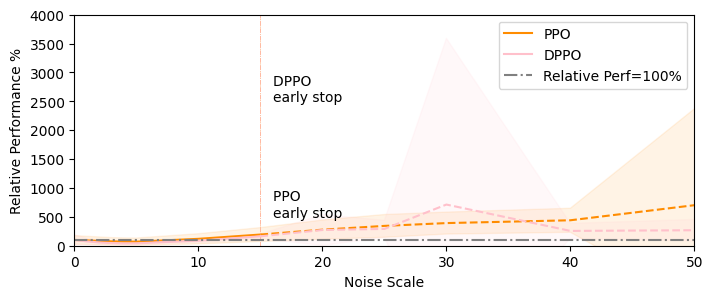

In [224]:
fig = plt.figure(figsize=(8, 3))
for method in metric.keys():
    print(method)
    temp, temp_std1, temp_std2 = [], [], []
    traj_success_till = 50
    count = 50
    for k, ns in enumerate(noise_scale):
        data = np.array(metric[method][ns]['rmse'])
        temp.append(data.mean())
        temp_std1.append(data.mean() - data.std())
        temp_std2.append(data.mean() + data.std())
        # print(all(metric[method][ns]['success']))
        if not all(metric[method][ns]['success']) and traj_success_till > ns:
            traj_success_till = ns
            count = k
    temp = np.array(temp)
    temp_std1, temp_std2 = np.array(temp_std1), np.array(temp_std2)
    print(traj_success_till)
    
    plt.plot(noise_scale[:count+1], temp[:count+1]*100/temp[0], color=plot_colors[method], label=method)
    plt.axvline(x=traj_success_till, linestyle='-.', linewidth=0.5, color=plot_colors[method])
    plt.plot(noise_scale[count:], temp[count:]*100/temp[0], color=plot_colors[method], linestyle='--')
    plt.fill_between(noise_scale, 
                     temp_std1*100/temp[0],  
                     temp_std2*100/temp[0], color=plot_colors[method], alpha=0.1)
    
    #plt.fill_between([traj_success_till, 100], [1, 1], color='r', alpha=0.25, label=method)

plt.plot(noise_scale, [100]*len(noise_scale), color='grey', linestyle='-.', label='Relative Perf=100%')
plt.text(16, 500, 'PPO \nearly stop')
#plt.text(31, 500, 'SAC \nearly stop')
plt.text(16, 2500, 'DPPO \nearly stop')


plt.legend()
plt.ylim(0,4000)
plt.xlim(0,50)
# plt.xscale("log")
# plt.gca().invert_xaxis()
# plt.yscale("log")
plt.xlabel("Noise Scale")
plt.ylabel("Relative Performance %")
#plt.title("TD3 for Quadrotor 2D")
plt.savefig("robustness_rl.pdf",bbox_inches="tight", pad_inches=0.1)

In [212]:
linear_mpc_data = np.load('./Data/noise_results_linear_mpc.npy', allow_pickle=True).item()
mpc_data = np.load('./Data/noise_results_mpc_acados.npy', allow_pickle=True).item()
gpmpc_data = np.load('./Data/noise_results_gpmpc_acados.npy', allow_pickle=True).item()

noise_data = {'Linear MPC': linear_mpc_data, 'Nonlinear MPC': mpc_data, 'GP-MPC': gpmpc_data} 
noise_scale = [0,1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]

91.0
91.0
121.0


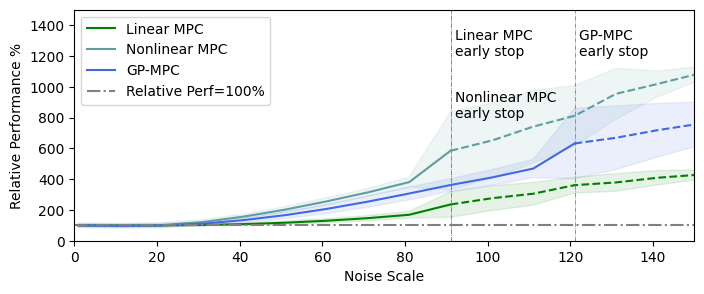

In [213]:
fig = plt.figure(figsize=(8, 3))
for method in noise_data.keys():
    temp1, temp2, temp3 = [], [], []
    for seed_str in noise_data[method]:
        temp1.append(noise_data[method][seed_str]['rmse'])
        temp2.append(noise_data[method][seed_str]['early_stop'])
        temp3.append(noise_data[method][seed_str]['noise_factor'])
    temp1 = np.array(temp1)
    temp2, temp3 = np.array(temp2).mean(axis=0), np.array(temp3).mean(axis=0)

    traj_success_till = 200
    count = 20
    temp, temp_std1, temp_std2 = [], [], []
    for k, ns in enumerate(temp3):
        temp.append(temp1[:, k].mean())
        temp_std1.append(temp1[:, k].mean() - 1*temp1[:, k].std())
        temp_std2.append(temp1[:, k].mean() + 1*temp1[:, k].std())
        if temp2[k] > 0.0 and traj_success_till > ns:
            traj_success_till = ns
            count = k
    temp, temp_std1, temp_std2 = np.array(temp), np.array(temp_std1), np.array(temp_std2)
    print(traj_success_till)
    
    plt.plot(temp3[:count+1], temp[:count+1]*100/temp[0], color=plot_colors[method], label=method)
    plt.axvline(x=traj_success_till, linestyle='-.', linewidth=0.5, color=plot_colors[method])
    plt.plot(temp3[count:], temp[count:]*100/temp[0], color=plot_colors[method], linestyle='--')
    plt.fill_between(temp3, 
                     temp_std1*100/temp[0],  
                     temp_std2*100/temp[0], color=plot_colors[method], alpha=0.1)
    
    #plt.fill_between([traj_success_till, 100], [1, 1], color='r', alpha=0.25, label=method)

plt.plot(noise_scale, [100]*len(noise_scale), color='grey', linestyle='-.', label='Relative Perf=100%')
plt.text(92, 1200, 'Linear MPC \nearly stop')
plt.text(92, 800, 'Nonlinear MPC \nearly stop')
plt.text(122, 1200, 'GP-MPC \nearly stop')

plt.legend()
plt.ylim(0, 1500)
plt.xlim(0, 150)
# plt.xscale("log")
# plt.gca().invert_xaxis()
# plt.yscale("log")
plt.xlabel("Noise Scale")
plt.ylabel("Relative Performance %")
plt.savefig("robustness_model-based.pdf",bbox_inches="tight", pad_inches=0.1)

## Robustness metric: Process Noise

In [227]:
metric = {}
noise_scale = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
for method in data_paths.keys():
    print(method)
    metric.update({method: {}})
    for seed in [0]:
        for ns in noise_scale:
            path = data_paths[method] + "/seed"+ str(seed) +"_*/robust_metric_ps_"+str(ns)+".npy"
            file_path = glob.glob(path)
            temp = np.load(file_path[0], allow_pickle=True).item()
            if ns in metric[method].keys():
                metric[method][ns]['rmse'].append(temp['rmse'])
                metric[method][ns]['rmse_std'].append(temp['rmse_std'])
                temp2 = True if temp['average_length'] >= 660.0 else False
                metric[method][ns]['success'].append(temp2)
            else:
                temp2 = True if temp['average_length'] >= 660.0 else False
                metric[method].update({ns: {'rmse': [temp['rmse']], 
                                            'rmse_std': [temp['rmse_std']], 
                                            'success': [temp2]}})

PPO
DPPO


PPO
40
DPPO
30


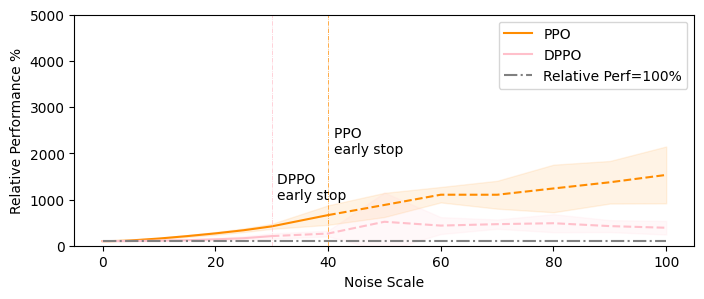

In [229]:
fig = plt.figure(figsize=(8, 3))
for method in metric.keys():
    print(method)
    temp, temp_std1, temp_std2 = [], [], []
    traj_success_till = 200
    count = 0
    for k, ns in enumerate(noise_scale):
        data = np.array(metric[method][ns]['rmse'])
        temp.append(data.mean())
        temp_std1.append(data.mean() - 1*data.std())
        temp_std2.append(data.mean() + 1*data.std())
        # print(all(metric[method][ns]['success']))
        if not all(metric[method][ns]['success']) and traj_success_till > ns:
            traj_success_till = ns
            count = k
    temp = np.array(temp)
    temp_std1, temp_std2 = np.array(temp_std1), np.array(temp_std2)
    print(traj_success_till)
    
    
    plt.plot(noise_scale[:count+1], temp[:count+1]*100/temp[0], color=plot_colors[method], label=method)
    plt.axvline(x=traj_success_till, linestyle='-.', linewidth=0.5, color=plot_colors[method])
    plt.plot(noise_scale[count:], temp[count:]*100/temp[0], color=plot_colors[method], linestyle='--')
    plt.fill_between(noise_scale, 
                     temp_std1*100/temp[0],  
                     temp_std2*100/temp[0], color=plot_colors[method], alpha=0.1)
    
    #plt.fill_between([traj_success_till, 100], [1, 1], color='r', alpha=0.25, label=method)

plt.plot(noise_scale, [100]*len(noise_scale), color='grey', linestyle='-.', label='Relative Perf=100%')
plt.text(41, 2000, 'PPO \nearly stop')
#plt.text(6, 1500, 'SAC \nearly stop')
plt.text(31, 1000, 'DPPO \nearly stop')


plt.legend()
plt.ylim(0,5000)
#plt.xlim(0,25)
# plt.xscale("log")
# plt.gca().invert_xaxis()
# plt.yscale("log")
plt.xlabel("Noise Scale")
plt.ylabel("Relative Performance %")
#plt.title("TD3 for Quadrotor 2D")
plt.savefig("robustness_ps_rl.pdf",bbox_inches="tight", pad_inches=0.1)

### Robustness Metric: Downwash

In [230]:
metric = {}
downwash_height = [1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5, 4.0, 4.5]
for method in data_paths.keys():
    print(method)
    metric.update({method: {}})
    for seed in seeds:
        for ns in downwash_height:
            path = data_paths[method] + "/seed"+ str(seed) +"_*/robust_metric_dw_"+str(ns)+".npy"
            file_path = glob.glob(path)
            temp = np.load(file_path[0], allow_pickle=True).item()
            if ns in metric[method].keys():
                metric[method][ns]['rmse'].append(temp['rmse'])
                metric[method][ns]['rmse_std'].append(temp['rmse_std'])
                temp2 = True if temp['average_length'] >= 660.0 else False
                metric[method][ns]['success'].append(temp2)
            else:
                temp2 = True if temp['average_length'] >= 660.0 else False
                metric[method].update({ns: {'rmse': [temp['rmse']], 
                                            'rmse_std': [temp['rmse_std']], 
                                            'success': [temp2]}})

PPO
DPPO


PPO
50
DPPO
50


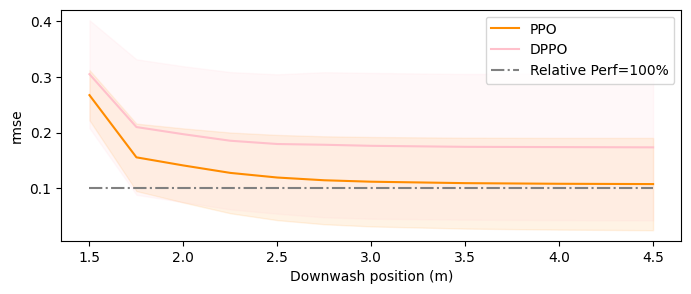

In [231]:
fig = plt.figure(figsize=(8, 3))

for method in metric.keys():
    print(method)
    temp, temp_std1, temp_std2 = [], [], []
    traj_success_till = 50
    count = 50
    for k, ns in enumerate(downwash_height):
        data = np.array(metric[method][ns]['rmse'])
        temp.append(data.mean())
        temp_std1.append(data.mean() - data.std())
        temp_std2.append(data.mean() + data.std())
        # print(all(metric[method][ns]['success']))
        if not all(metric[method][ns]['success']) and traj_success_till > ns:
            traj_success_till = ns
            count = k
    temp = np.array(temp)
    temp_std1, temp_std2 = np.array(temp_std1), np.array(temp_std2)
    print(traj_success_till)
    
    plt.plot(downwash_height, temp, color=plot_colors[method], label=method)
    #plt.axvline(x=traj_success_till, linestyle='-.', linewidth=0.5, color=plot_colors[method])
    #plt.plot(downwash_height[count:], temp[count:]*100/temp[0], color=plot_colors[method], linestyle='--')
    plt.fill_between(downwash_height, 
                     temp_std1,  
                     temp_std2, color=plot_colors[method], alpha=0.1)
    
    #plt.fill_between([traj_success_till, 100], [1, 1], color='r', alpha=0.25, label=method)

plt.plot(downwash_height, [0.1]*len(downwash_height), color='grey', linestyle='-.', label='Relative Perf=100%')
#plt.text(16, 100, 'PPO \nearly stop')
#plt.text(31, 500, 'SAC \nearly stop')
#plt.text(11, 100, 'DPPO \nearly stop')


plt.legend()
#plt.ylim(0,100)
#plt.xlim(0,50)
# plt.xscale("log")
# plt.gca().invert_xaxis()
# plt.yscale("log")
plt.xlabel("Downwash position (m)")
plt.ylabel("rmse")
#plt.title("TD3 for Quadrotor 2D")
plt.savefig("robustness_dw_rl.pdf",bbox_inches="tight", pad_inches=0.1)

### Rough plots for individual seeds

In [16]:
colors = {
    "ref": "black",
    "PPO": "orange",
    "PPO2": "red",
    "PPO3": "tab:cyan",
    "PPO4": "royalblue",
    "DPPO": "darkorange",
    "DPPO2": "red",
    "DPPO3": "tab:cyan",
    "DPPO4": "royalblue",
    "SAC": "royalblue",
    "iLQR": "tab:gray",
}
legends = {
    "PPO": "PPO",
    "PPO2": "2",
    "PPO3": "3",
    "PPO4": "4",
    "DPPO": "DPPO",
    "DPPO2": "2",
    "DPPO3": "3",
    "DPPO4": "4",
    "SAC": "SAC"
}
seeds = [i for i in range(0,5)]

In [18]:
data_paths = {
    "PPO": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_ppo_data/",
    #"PPO2": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_ppo_data2/",
    #"PPO3": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_ppo_data3/",
    #"PPO4": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_ppo_data4/",
    #"DPPO": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_dppo_data/",
    #"DPPO2": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_dppo_data2/",
    #"DPPO3": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_dppo_data3/",
    #"DPPO4": "/home/savvyfox/Projects/scg-exp/examples/rl/Results/Benchmark_data/standard_ref/quadrotor_2D_attitude_dppo_data4/",
    
    #'PPO': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Test_runs/quadrotor_2D_attitude_ppo_data/',

    #'PPO': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs/quadrotor_2D_attitude_ppo_data/',
    #'PPO': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs/quadrotor_2D_attitude_ppo_data2/',
    #'DPPO': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs/quadrotor_2D_attitude_dppo_data2/',
    #'SAC': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs/quadrotor_2D_attitude_sac_data2/',
    
    #'PPO': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs_new/quadrotor_2D_attitude_ppo_data/',
    #'PPO2': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs_new/quadrotor_2D_attitude_ppo_data2/',
    #'PPO3': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs_new/quadrotor_2D_attitude_ppo_data3/',
    #'PPO': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs_new/quadrotor_2D_attitude_ppo_data2/',
    #'DPPO': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs_new/quadrotor_2D_attitude_dppo_data/',
    #'DPPO2': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs_new/quadrotor_2D_attitude_dppo_data2/',
    #'DPPO3': '/home/savvyfox/Misc/lsy_pc1/Projects/scg-exp/examples/rl/Results/Benchmark_runs_new/quadrotor_2D_attitude_dppo_data3/',
    
}

perf_data = {}
for method in data_paths.keys():
    print(method)
    perf_data.update({method: {}})
    for seed in seeds:
        # print(data_paths[method] + str(seed) + "/logs/stat_eval/ep_length.log")
        xk, x, lk, l = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_length.log")
        xk, x, yk, y = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_return.log")
        xk, x, zk, z = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/ep_return_std.log")
        # xk, x, ck, c = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/constraint_violation.log")
        # perf_data[method].update({seed: {"x": x, "y": y, "c": c}})
        # perf_data[method].update({seed: {"x": x, "y": y, "z": z, "c": c}})
        xk, x, yk, m = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/rmse.log")
        xk, x, yk, n = load_from_log_file(data_paths[method] + str(seed) + "/logs/stat_eval/rmse_std.log")
        # perf_data[method].update({"x": x, "y": y, "z": z, "x1": x1, "y1": y1, "z1": z1})
        perf_data[method].update({seed: {"x": x, "y": y, "z": z, "m": m, "n": n, "l": l}})

PPO


In [144]:
eval_data = {}
w = 1
fig = plt.figure(figsize=(8, 3))
mean_fn = np.percentile
perc = 90
plot_seeds = True

for t, method in enumerate(data_paths.keys()):
    print(method)
    temp = np.zeros((len(seeds), 6, perf_data[method][seeds[0]]["x"].shape[0]))
    for seed in seeds:
        temp[seed, 0, :] = perf_data[method][seed]["x"]
        temp[seed, 1, :] = perf_data[method][seed]["y"]
        temp[seed, 2, :] = perf_data[method][seed]["z"]
        temp[seed, 3, :] = perf_data[method][seed]["m"]
        temp[seed, 4, :] = perf_data[method][seed]["n"]
        temp[seed, 5, :] = perf_data[method][seed]["l"]
    j_max = 0
    for seed in seeds:
        for j,k in enumerate(temp[seed, 0, :]):
            if temp[seed, 5, j] < 660:
                temp[seed, 1, j] = np.nan
                temp[seed, 2, j] = np.nan
                temp[seed, 3, j] = np.nan
                temp[seed, 4, j] = np.nan
    eval_data.update({method: temp})

    # plot
    plt.plot(temp[0,0,:], mean_fn(temp[:,3,:], perc, axis=0), color=colors[method], label=legends[method])
    plt.fill_between(temp[0,0,:], 
                     np.clip(mean_fn(temp[:,3,:]+w*temp[:,4,:], perc, axis=0), 0, 10),  
                     np.clip(mean_fn(temp[:,3,:]-w*temp[:,4,:], perc, axis=0), 0, 10), color=colors[method], alpha=0.2)
    if plot_seeds:
        for seed in seeds:
            plt.plot(temp[seed,0,:], temp[seed,3,:], label=seed)
            plt.fill_between(temp[0,0,:], 
                             np.clip(temp[seed,3,:]-w*temp[seed,4,:], 0, 10),  
                             np.clip(temp[seed,3,:]+w*temp[seed,4,:], 0, 10), alpha=0.)



# s = 1 # time std
# rmse_ilqr_mean = 0.026000000000000002 * 0
# rmse_ilqr_std = 0.001843908891458577 * 0
plt.axhline(xmin=0.0, xmax=1.95, y=0.1, linestyle='-.', color=colors["iLQR"], label='rmse=0.1')
# plt.fill_between([0.0, last_iter], rmse_ilqr_mean-s*rmse_ilqr_std, rmse_ilqr_mean+s*rmse_ilqr_std, color=colors["iLQR"], alpha=0.25)

# real experiment data
# plt.plot(last_iter, 0.086, color=colors['PPO'], marker='x')
# plt.plot(last_iter, 0.064, color=colors['SAC'], marker='x')

plt.legend(ncol=3)
# plt.ylim(-200,00)
# plt.xlim(right=6e5)
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Training steps")
plt.ylabel("RMSE")
#plt.title("Task: Quadrotor 2D")
#plt.savefig("performance_logx.pdf",bbox_inches="tight", pad_inches=0.0)

PPO


KeyError: 'x'

<Figure size 800x300 with 0 Axes>

In [7]:
mean_fn = np.mean
for method in eval_data.keys():
    print(method)
    print(mean_fn(eval_data[method][:, 3, :], axis=0))

PPO
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.26790361 0.22807108 0.18980713 0.16330053 0.13762581
 0.1207609  0.10932789 0.0900497  0.07063229 0.0585894  0.0466095
 0.0460997  0.04961646 0.04840762 0.04278864 0.03734574 0.03677834
 0.03701848 0.03908621 0.03867297 0.0360975  0.03486813 0.04169359
 0.03725969 0.03457009 0.03849986 0.03885277 0.0400471  0.04342527
 0.041256   0.0388206  0.03144821 0.03468308 0.03563006 0.03330509
 0.03826558 0.07731813]
DPPO
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.25586162 0.24190134 0.22537191 0.20194781 0.18302899
 0.17394095 0.15722846 0.13726